# Benchmarking SAM with IPEX

In [18]:
#!pip install -U -e /home/wayne/ov/segment-anything

Obtaining file:///home/wayne/ov/segment-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything


In [1]:
import torch
import intel_extension_for_pytorch as ipex
from segment_anything import sam_model_registry, SamPredictor

/home/wayne/.env/ov/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from PIL import Image
import torchvision.transforms as T
def load_image(image_path, size=[384, 384]):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = transform(image_pil)
    return image_pil, image

In [3]:
import numpy as np
# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [4]:
image_path = 'assets/demo2.jpg'

In [5]:
image_pil, image = load_image(image_path)

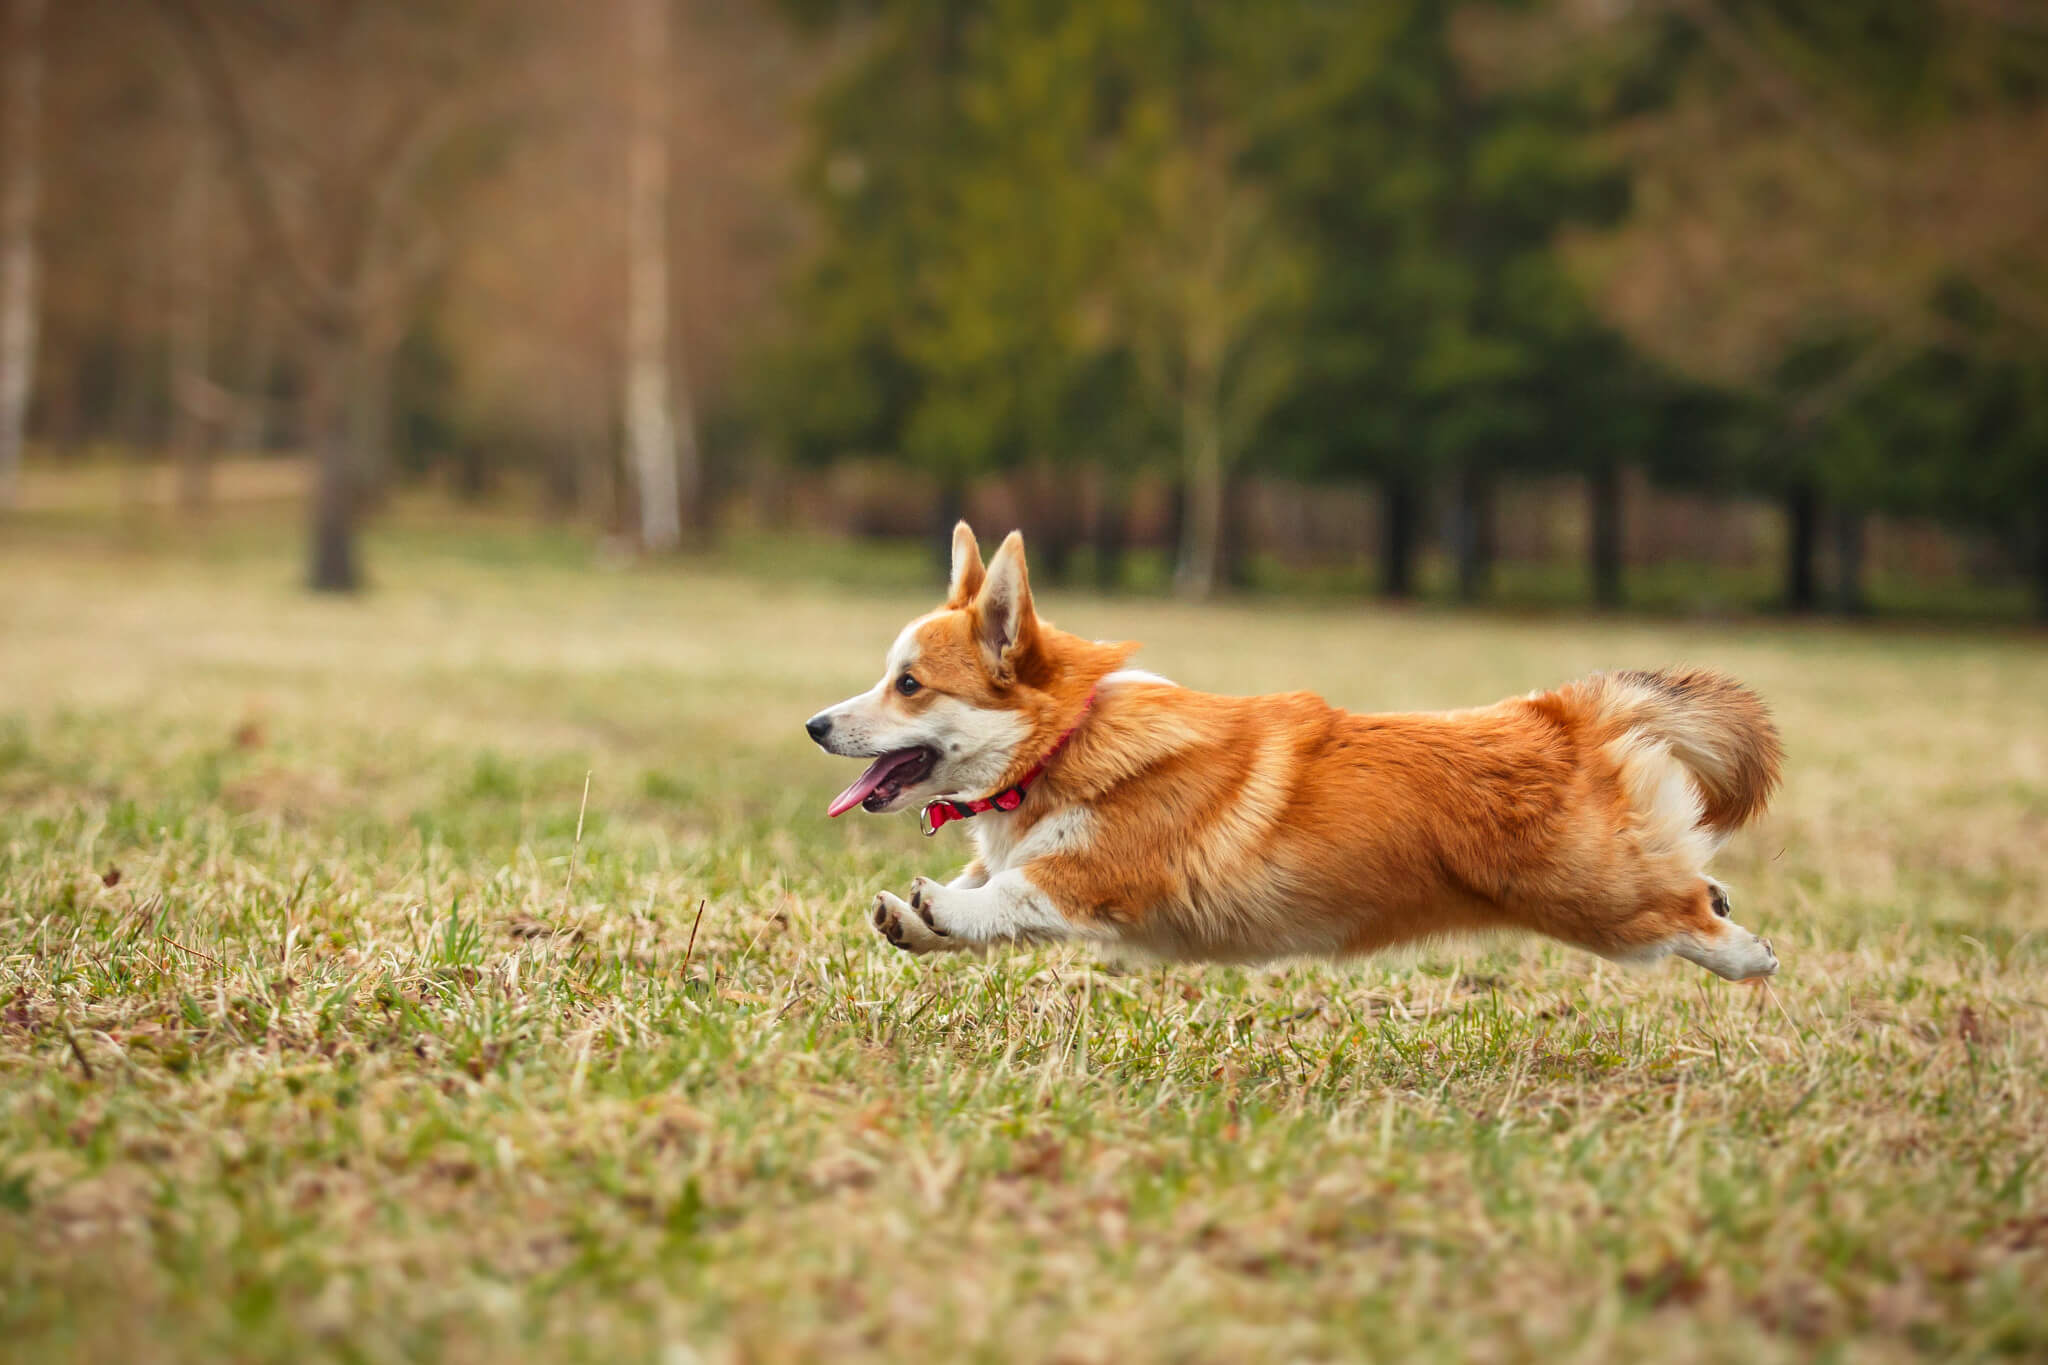

In [6]:
image_pil

In [6]:
device = torch.device('xpu')

In [7]:
image = image.to(device)

In [8]:
ckpts = {'vit_b': './checkpoints/sam_vit_b_01ec64.pth',
         'vit_l': './checkpoints/sam_vit_l_0b3195.pth',
         'vit_h': './checkpoints/sam_vit_h_4b8939.pth'}

In [9]:
SAM_ENCODER_VERSION = "vit_h"
#SAM_CHECKPOINT_PATH = "./checkpoints/sam_vit_h_4b8939.pth"

In [10]:
SAM_ENCODER_VERSION = "vit_l"
#SAM_CHECKPOINT_PATH = "./checkpoints/sam_vit_h_4b8939.pth"

In [9]:
SAM_ENCODER_VERSION = "vit_b"
#SAM_CHECKPOINT_PATH = "./checkpoints/sam_vit_h_4b8939.pth"

In [10]:
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=ckpts[SAM_ENCODER_VERSION])

In [11]:
sam = sam.to(device)
sam = ipex.optimize(sam)

/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [12]:
sam_predictor = SamPredictor(sam)

In [13]:
sam_predictor.set_image(image)

In [14]:
%timeit sam_predictor.set_image(image)

224 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit -n 10 sam_predictor.set_image(image)

225 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit sam_predictor.predict(box=np.array([0, 0, 2048, 1365]), multimask_output=True)

11 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit sam_predictor.predict(box=np.array([0, 0, 512, 512]), multimask_output=True)

10.7 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
data = torch.randn([3,384,384]).to(device)
%timeit sam_predictor.set_image(data)

892 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
hf_sam = sam.half()

In [12]:
hf_sam = hf_sam.to(device)
hf_sam = ipex.optimize(hf_sam)

/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/wayne/.env/ov/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [13]:
hf = SamPredictor(sam)

In [14]:
%timeit hf.set_image(image)

109 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit -n 10 hf.set_image(image)

110 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit hf.predict(box=np.array([0, 0, 2048, 1365]), multimask_output=True)

11.1 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit -n 10 hf.predict(box=np.array([0, 0, 2048, 1365]), multimask_output=True)

11.4 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
hf.set_image(image.to(torch.float16))

In [37]:
detections = sv.Detections(xyxy=xyxy, confidence=confidence, class_id = class_ids)
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=np.array(image_pil),
    xyxy=detections.xyxy
)

In [40]:
# annotate image with detections
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(scene=np.array(image_pil), detections=detections)